In [1]:
!pip install geopy

In [2]:
'''To import the required packages.'''
import pandas as pd
import numpy as np
import networkx as nx
import collections
import matplotlib.pyplot as plt
import math
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

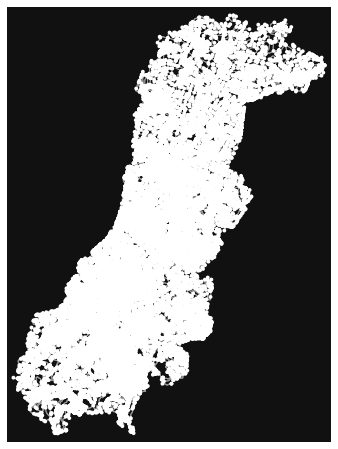

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa098bdafa0>)

In [3]:
import osmnx as ox
ox.plot_graph(ox.graph_from_place('Modena, Italy'))

# Settings


In [4]:
'''To display all output results of a Jupyter cell.'''
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
'''To ensure that the output results of extensive output results are not truncated.'''
#pd.options.display.max_rows = 4000

'To ensure that the output results of extensive output results are not truncated.'

# **Belgian railway system**

# Import of the Belgian railway datasets

In [6]:
'''To register the GitHub link with the Belgian data as a variable.'''
datalink = "https://raw.githubusercontent.com/polkuleuven/Thesis_Train/main/gtfs_train_Belgium_1503/"

'To register the GitHub link with the Belgian data as a variable.'

In [7]:
'''Import all the GTFS data'''

#To import the agency dataset that contains limited information about Belgian NMBS/SNCB railway agency
agency = pd.read_csv(datalink + "agency.txt", sep=",")
#To import the stops dataset that contains information about the ids, the names and the geographical coordinates of the Belgian railway stations.
stops = pd.read_csv(datalink + "stops.txt", sep=",")
#To import the translations dataset that provides the French-, Dutch-, German- and English-language translations of the Belgian railway stations.
translations = pd.read_csv(datalink + "translations.txt", sep=",")
#To import the transfers dataset that gives the minimum transfer time to switch routes at each Belgian railway station.
transfers = pd.read_csv(datalink + "transfers.txt", sep=",")
#To import the routes dataset that provides the id, the name and the type of vehicle used for all Belgian railway routes.
routes = pd.read_csv(datalink + "routes.txt", sep=",")
#To import the trips dataset that gives for all routes an overview of the trips and the headsigns of these trips belonging to the Belgian railway route.
#The service_id is an indication of all the dates this trip is valid (consultable in the calendar_dates dataset).
trips = pd.read_csv(datalink + "trips.txt", sep=",")
#To import the stop_times dataset that gives for all trips an overview of the ids of the stations served and the sequence in which these stations are served. 
#In addition, for all the trips the arrival and departure times at the stations served are given.
stop_times = pd.read_csv(datalink + "stop_times.txt", sep=",")
#To import the calendar dataset that gives the first and last date of all data observations.
calendar = pd.read_csv(datalink + "calendar.txt", sep=",")
#To import the calendar_dates dataset that gives for each service_id all the exact dates when that service_id is valid.
calendar_dates = pd.read_csv(datalink + "calendar_dates.txt", sep=",")
#???
stop_time_overrides = pd.read_csv(datalink + "stop_time_overrides.txt", sep=",")

'Import all the GTFS data'

# Cleaning of the Belgian railway data

''' To clean the stops df.  (1) ''' 
#####To eliminate the stop_ids in the stops dataset that contain an underscore or that start with a character 'S'. 
stops_cleaned = stops[(~stops['stop_id'].str.contains('_')) & (~stops['stop_id'].str.contains('S'))]

#####To modify the object datatype of the stop_id column to the numpy int64 datatype
stops_cleaned.loc[:,'stop_id'] = stops_cleaned.loc[:,'stop_id'].astype(np.int64)

##### To remove the accents from the stop_name and to change to uppercase
stops_cleaned.loc[:,'stop_name'] = stops_cleaned.loc[:,'stop_name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
stops_cleaned.loc[:,'stop_name'] = stops_cleaned.loc[:,'stop_name'].str.upper()

''' To clean the stops df.  (2) ''' 
##### To initialize the Nominatim API to get the location from the input string 
geolocator = Nominatim(user_agent="application")
reverse = RateLimiter(geolocator.reverse, min_delay_seconds=0.2)

##### To get the location with the geolocator.reverse() function and to extract the country from the location instance
country_list = []
for index, row in stops_cleaned.iterrows():
    latitude = row['stop_lat']
    longitude = row['stop_lon']
    # To assign the latitude and longitude into a geolocator.reverse() method
    location = reverse((latitude, longitude), language='en', exactly_one=True)
    # To get the country from the given list and parsed into a dictionary with raw function()
    address = location.raw['address']
    country = address.get('country', '')
    country_list.append(country)

##### To add the values of country_list as a new attribute country 
stops_cleaned.loc[:,'country'] = country_list
stops_cleaned

##### To calculate the total number of Belgian stations in the stops_cleaned dataset
belgian_stops_Belgium = stops_cleaned[stops_cleaned['country'] == 'Belgium']
belgian_stops_Belgium_series = stops_cleaned.loc[stops_cleaned['country'] == 'Belgium', 'stop_name']

stops_cleaned.to_csv(r'/Users/pol/Desktop/CSV_export/stops_cleaned_Belgium.csv', index = False, header=True, encoding='utf-8-sig')

belgian_stops_Belgium_series.to_csv(r'/Users/pol/Desktop/CSV_export/belgian_stops_Belgium_series.csv', index = False, header=True, encoding='utf-8-sig')

In [8]:
'''Imports the cleaned version of the stops with their country'''
stops_cleaned = pd.read_csv("https://raw.githubusercontent.com/polkuleuven/Thesis_Train/main/stops_cleaned/stops_cleaned_Belgium.csv", sep=",")
belgian_stops_Belgium_series = pd.read_csv("https://raw.githubusercontent.com/polkuleuven/Thesis_Train/main/country_stops_series/stops_Belgium_series.csv", sep=",")['stop_name']

'Imports the cleaned version of the stops with their country'

In [9]:
'''To clean the trips df'''
#To merge a selection of the trips dataset and a selection of the routes dataset on route_id
trip_route_short_name = pd.merge(trips[['route_id','service_id','trip_id', 'trip_headsign']], routes[['route_id', 'route_short_name', 'route_long_name']], on='route_id')

#To select the trips that belong to the routes that have a route_short_name that begins with an 'S' or is equal to 'IC', 'L' or 'P.'''
allowed_route_type = {'IC', 'L', 'P', 'ICT', 'IZY'}
filtered_trips = trip_route_short_name[(trip_route_short_name['route_short_name'].isin(allowed_route_type)) | (trip_route_short_name['route_short_name'].str.startswith('S'))]
filtered_trips = filtered_trips.drop(columns=['route_short_name'])

# To remove the accents from the route_long_name and to change to uppercase
filtered_trips['route_long_name'] = filtered_trips['route_long_name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
filtered_trips['route_long_name'] = filtered_trips['route_long_name'].str.upper()

# To remove the accents from the trip_headsign and to change to uppercase
filtered_trips['trip_headsign'] = filtered_trips['trip_headsign'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
filtered_trips['trip_headsign'] = filtered_trips['trip_headsign'].str.upper()
filtered_trips

'To clean the trips df'

,route_id,service_id,trip_id,trip_headsign,route_long_name
4845,115,14,88____:007::8885704:8885001:4:523:20210418,TOURNAI,TOURNAI -- MOUSCRON
4846,115,14,88____:007::8885704:8885001:4:623:20210418,TOURNAI,TOURNAI -- MOUSCRON
4847,115,14,88____:007::8885704:8885001:4:723:20210418,TOURNAI,TOURNAI -- MOUSCRON
4848,115,14,88____:007::8885704:8885001:4:823:20210418,TOURNAI,TOURNAI -- MOUSCRON
4849,115,14,88____:007::8885704:8885001:4:923:20210418,TOURNAI,TOURNAI -- MOUSCRON
...,...,...,...,...,...
30831,734,25,88____:007::8821105:8812005:22:1323:20210418,BRUXELLES-NORD,DEN HAAG HS (NL) -- BRUXELLES-NORD
30832,734,25,88____:007::8812005:8400131:23:1618:20210418,DEN HAAG HS (NL),DEN HAAG HS (NL) -- BRUXELLES-NORD
30833,734,25,84____:007::8400131:8400280:3:1720:20210418,DEN HAAG HS (NL),DEN HAAG HS (NL) -- BRUXELLES-NORD
30834,734,25,84____:007::8400280:8821105:4:1600:20210418,BRUXELLES-NORD,DEN HAAG HS (NL) -- BRUXELLES-NORD


In [10]:
'''Filters the dats from the selected begin to the end date'''
#here we used 4 months
begin_date = 20210314
end_date = 20210713
filtered_calendar_dates = calendar_dates.copy()
filtered_calendar_dates = filtered_calendar_dates.drop(filtered_calendar_dates[(filtered_calendar_dates['date'] > end_date) |(filtered_calendar_dates['date'] < begin_date)].index)
filtered_calendar_dates

'Filters the dats from the selected begin to the end date'

,service_id,date,exception_type
0,1,20210314,1
1,2,20210315,1
2,2,20210316,1
3,2,20210317,1
4,2,20210318,1
...,...,...,...
487564,0,20210709,1
487565,0,20210710,1
487566,0,20210711,1
487567,0,20210712,1


# Exploratory data analysis with the Belgian railway data

In [11]:
'''To calculate the number of unique route_ids before removing the routes with a route_short_name that does not begin with an S and is not 'IC', 'L', or 'P'.'''
initial_set_routes = {r for r in routes['route_id']}
len(initial_set_routes)

"To calculate the number of unique route_ids before removing the routes with a route_short_name that does not begin with an S and is not 'IC', 'L', or 'P'."

734

In [12]:
'''To calculate the number of unique route_ids after removing the routes with a route_short_name that does not begin with an S and is not 'IC', 'L', or 'P'.'''
set_routes = {r for r in filtered_trips['route_id']}
len(set_routes)

"To calculate the number of unique route_ids after removing the routes with a route_short_name that does not begin with an S and is not 'IC', 'L', or 'P'."

606

In [13]:
'''To calculate the total number of stations in the stops_cleaned dataset'''
set_stations = {s for s in stops_cleaned['stop_id']}
len(set_stations)

'To calculate the total number of stations in the stops_cleaned dataset'

608

In [14]:
'''To calculate the total number of Belgian stations in the stops_cleaned dataset'''
len(belgian_stops_Belgium_series)

'To calculate the total number of Belgian stations in the stops_cleaned dataset'

564

# **Preparation for the L-space representation of the Belgian railway system**


In [15]:
'''To merge a selection of the stops_cleaned dataset with a selection of the stop_times dataset'''
stops_cleaned_stop_times_merge = pd.merge(stop_times[['trip_id','arrival_time', 'departure_time','stop_id','stop_sequence']], stops_cleaned[['stop_id', 'stop_name', 'stop_lat', 'stop_lon']], on='stop_id')
stops_cleaned_stop_times_merge

'To merge a selection of the stops_cleaned dataset with a selection of the stop_times dataset'

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_name,stop_lat,stop_lon
0,88____:049::8892338:8892205:6:1925:20210314,17:35:00,17:35:00,8892338,1,LA PANNE,51.07740,2.601966
1,88____:049::8892338:8892205:6:720:20210314,05:30:00,05:30:00,8892338,1,LA PANNE,51.07740,2.601966
2,88____:049::8892338:8892205:6:820:20210314,06:30:00,06:30:00,8892338,1,LA PANNE,51.07740,2.601966
3,88____:049::8892338:8892205:6:920:20210314,07:30:00,07:30:00,8892338,1,LA PANNE,51.07740,2.601966
4,88____:049::8892338:8892205:6:1020:20210314,08:30:00,08:30:00,8892338,1,LA PANNE,51.07740,2.601966
...,...,...,...,...,...,...,...,...
460669,87____:005::8727100:8814308:2:1434:20210424,12:31:00,12:31:00,8727100,1,PARIS NORD (FR),48.86667,2.333333
460670,87____:005::8727100:8814308:2:1432:20211211,12:31:00,12:31:00,8727100,1,PARIS NORD (FR),48.86667,2.333333
460671,88____:005::8814001:8727100:3:1756:20211210,17:56:00,17:56:00,8727100,3,PARIS NORD (FR),48.86667,2.333333
460672,87____:005::8727100:8814308:2:2111:20210430,18:49:00,18:49:00,8727100,1,PARIS NORD (FR),48.86667,2.333333


In [16]:
'''To merge a selection of the stops_cleaned_stop_times_merge dataset with the filtered_trips dataset. And sort the values.'''
stops_cleaned_stop_times_trips_merge = pd.merge(filtered_trips, stops_cleaned_stop_times_merge, on='trip_id')
stops_cleaned_stop_times_trips_merge = stops_cleaned_stop_times_trips_merge.sort_values(by=['route_id', 'trip_id', 'stop_sequence'])
stops_cleaned_stop_times_trips_merge

'To merge a selection of the stops_cleaned_stop_times_merge dataset with the filtered_trips dataset. And sort the values.'

,route_id,service_id,trip_id,trip_headsign,route_long_name,arrival_time,departure_time,stop_id,stop_sequence,stop_name,stop_lat,stop_lon
100,115,14,88____:007::8885001:8885704:4:1052:20210418,MOUSCRON,TOURNAI -- MOUSCRON,10:36:00,10:36:00,8885001,1,TOURNAI,50.61313,3.396940
101,115,14,88____:007::8885001:8885704:4:1052:20210418,MOUSCRON,TOURNAI -- MOUSCRON,10:40:00,10:40:00,8885068,2,FROYENNES,50.62989,3.354835
102,115,14,88____:007::8885001:8885704:4:1052:20210418,MOUSCRON,TOURNAI -- MOUSCRON,10:47:00,10:47:00,8885753,3,HERSEAUX,50.71390,3.245961
103,115,14,88____:007::8885001:8885704:4:1052:20210418,MOUSCRON,TOURNAI -- MOUSCRON,10:52:00,10:52:00,8885704,4,MOUSCRON,50.74100,3.228449
260,115,42,88____:007::8885001:8885704:4:1052:20210530,MOUSCRON,TOURNAI -- MOUSCRON,10:36:00,10:36:00,8885001,1,TOURNAI,50.61313,3.396940
...,...,...,...,...,...,...,...,...,...,...,...,...
431485,734,25,88____:007::8821105:8812005:22:1723:20210418,BRUXELLES-NORD,DEN HAAG HS (NL) -- BRUXELLES-NORD,17:05:00,17:05:00,8811254,21,KORTENBERG,50.89307,4.543300
431484,734,25,88____:007::8821105:8812005:22:1723:20210418,BRUXELLES-NORD,DEN HAAG HS (NL) -- BRUXELLES-NORD,17:07:00,17:07:00,8811247,22,NOSSEGEM,50.88331,4.506110
431489,734,25,88____:007::8821105:8812005:22:1723:20210418,BRUXELLES-NORD,DEN HAAG HS (NL) -- BRUXELLES-NORD,17:10:00,17:12:00,8819406,23,BRUSSELS AIRPORT-ZAVENTEM,50.89646,4.482072
431483,734,25,88____:007::8821105:8812005:22:1723:20210418,BRUXELLES-NORD,DEN HAAG HS (NL) -- BRUXELLES-NORD,17:20:00,17:20:00,8811007,24,SCHAERBEEK,50.87851,4.378640


In [17]:
'''Creates a dataframe with the departure time form the first stop sequence and with the one from last stop sequence for each trip_id'''
departure_time_first = stops_cleaned_stop_times_trips_merge.reset_index().loc[stops_cleaned_stop_times_trips_merge.reset_index().groupby(['trip_id'])['stop_sequence'].idxmin()][['route_id', 'trip_id', 'departure_time']].copy()
departure_time_first = departure_time_first.rename(columns = {'departure_time': 'departure_time_first'})
departure_time_last = stops_cleaned_stop_times_trips_merge.reset_index().loc[stops_cleaned_stop_times_trips_merge.reset_index().groupby(['trip_id'])['stop_sequence'].idxmax()][['route_id', 'trip_id', 'departure_time']].copy()
departure_time_last = departure_time_last.rename(columns = {'departure_time': 'departure_time_last'})
departure_times = departure_time_first.merge(departure_time_last[['trip_id', 'departure_time_last']], on='trip_id')
departure_times

'Creates a dataframe with the departure time form the first stop sequence and with the one from last stop sequence for each trip_id'

,route_id,trip_id,departure_time_first,departure_time_last
0,469,80____:046::8015345:8849023:2:1011:20210328,10:04:00,10:11:00
1,469,80____:046::8015345:8849023:2:1011:20210402,10:04:00,10:11:00
2,469,80____:046::8015345:8849023:2:1011:20210405,10:04:00,10:11:00
3,469,80____:046::8015345:8849023:2:1011:20210411,10:04:00,10:11:00
4,469,80____:046::8015345:8849023:2:1011:20210416,10:04:00,10:11:00
...,...,...,...,...
25835,474,88____:L73::8843208:8841004:5:834:20211210,08:15:00,08:36:00
25836,474,88____:L73::8843208:8841400:13:1709:20210402,16:15:00,17:09:00
25837,474,88____:L73::8843208:8841400:13:1809:20210402,17:15:00,18:09:00
25838,474,88____:L73::8843208:8841400:13:809:20210402,07:15:00,08:09:00


In [18]:
''' To groupby the trip_id and to order the stop_sequence in an ascending order
Otherwise, different hash values could correspond to a same stop_sequence (since the stop_sequences of some
routes are initially in descending order while other stop_sequences are in ascending order)'''

trip_stop_sequence_ascending = stops_cleaned_stop_times_merge.groupby(['trip_id'], as_index=False).apply(lambda x: x.sort_values('stop_sequence'))
trip_stop_sequence_ascending

' To groupby the trip_id and to order the stop_sequence in an ascending order\nOtherwise, different hash values could correspond to a same stop_sequence (since the stop_sequences of some\nroutes are initially in descending order while other stop_sequences are in ascending order)'

trip_id arrival_time  \
0     83181   80____:046::8015345:8849023:2:1011:20210328     10:04:00   
      82814   80____:046::8015345:8849023:2:1011:20210328     10:11:00   
1     83179   80____:046::8015345:8849023:2:1011:20210402     10:04:00   
      82810   80____:046::8015345:8849023:2:1011:20210402     10:11:00   
2     83186   80____:046::8015345:8849023:2:1011:20210405     10:04:00   
...                                                   ...          ...   
30835 212160  88____:L73::8843208:8841400:13:909:20210402     08:54:00   
      211763  88____:L73::8843208:8841400:13:909:20210402     08:57:00   
      211366  88____:L73::8843208:8841400:13:909:20210402     09:01:00   
      210969  88____:L73::8843208:8841400:13:909:20210402     09:05:00   
      210572  88____:L73::8843208:8841400:13:909:20210402     09:09:00   

             departure_time  stop_id  stop_sequence              stop_name  \
0     83181        10:04:00  8015345              1        AACHEN HBF (DE)   
      82814        10:11:00  8849023              2   HERGENRATH-FRONTIERE   
1     83179        10:04:00  8015345              1        AACHEN HBF (DE)   
      82810        10:11:00  8849023              2   HERGENRATH-FRONTIERE   
2     83186        10:04:00  8015345              1        AACHEN HBF (DE)   
...                     ...      ...            ...                    ...   
30835 212160       08:54:00  8841467              9  FEXHE-LE-HAUT-CLOCHER   
      211763       08:57:00  8841459             10                MOMALLE   
      211366       09:01:00  8841442             11              REMICOURT   
      210969       09:05:00  8841434             12                 BLERET   
      210572       09:09:00  8841400             13                WAREMME   

              stop_lat  stop_lon  
0     83181   50.77083  6.105277  
      82814   50.71896  6.041269  
1     83179   50.77083  6.105277  
      82810   50.71896  6.041269  
2     83186   50.77083  6.105277  
...                ...       ...  
30835 212160  50.66405  5.398450  
      211763  50.66991  5.367600  
      211366  50.67861  5.321410  
      210969  50.68507  5.286398  
      210572  50.69455  5.249480  

[460674 rows x 8 columns]

In [19]:
'''To put the stop_names per trip_id in a list'''
trip_stop_sequence = trip_stop_sequence_ascending.groupby('trip_id')['stop_name'].apply(lambda group_series: group_series.tolist()).reset_index()
trip_stop_sequence.rename(columns={'stop_name':'stop_sequence'}, inplace=True)
trip_stop_sequence

'To put the stop_names per trip_id in a list'

,trip_id,stop_sequence
0,80____:046::8015345:8849023:2:1011:20210328,"[AACHEN HBF (DE), HERGENRATH-FRONTIERE]"
1,80____:046::8015345:8849023:2:1011:20210402,"[AACHEN HBF (DE), HERGENRATH-FRONTIERE]"
2,80____:046::8015345:8849023:2:1011:20210405,"[AACHEN HBF (DE), HERGENRATH-FRONTIERE]"
3,80____:046::8015345:8849023:2:1011:20210411,"[AACHEN HBF (DE), HERGENRATH-FRONTIERE]"
4,80____:046::8015345:8849023:2:1011:20210416,"[AACHEN HBF (DE), HERGENRATH-FRONTIERE]"
...,...,...
30831,88____:L73::8843208:8841004:5:834:20211210,"[FLEMALLE-HAUTE, SERAING, OUGREE, Y.RENORY, LI..."
30832,88____:L73::8843208:8841400:13:1709:20210402,"[FLEMALLE-HAUTE, SERAING, OUGREE, Y.RENORY, LI..."
30833,88____:L73::8843208:8841400:13:1809:20210402,"[FLEMALLE-HAUTE, SERAING, OUGREE, Y.RENORY, LI..."
30834,88____:L73::8843208:8841400:13:809:20210402,"[FLEMALLE-HAUTE, SERAING, OUGREE, Y.RENORY, LI..."


In [20]:
'''To calculate the hash value for the stop sequence of each trip_id
and also the hash value of the stop sequence in the opposite direction'''

#To copy the filtered_trips dataset
trips_hash = trip_stop_sequence.copy()

#calculates the hash of the stop sequence in both order (ascending and descending)
trips_hash['hash'] = trips_hash['stop_sequence'].apply(lambda x: hash(tuple(x)))
trips_hash['hash_inverse'] = trips_hash['stop_sequence'].apply(lambda x: hash(tuple(x[::-1])))

'To calculate the hash value for the stop sequence of each trip_id\nand also the hash value of the stop sequence in the opposite direction'

In [21]:
''' To add the list of stop_sequence of stations to the trips_hash df by joining on trip_id'''
# To add the stop_sequence of stations to the filtered_trips dataset by joining on trip_id
trips_hash_stop_sequence = pd.merge(filtered_trips, trips_hash, on='trip_id', how='left')

# To put the columns in a more logical order
trips_hash_stop_sequence = trips_hash_stop_sequence[['route_id', 'route_long_name','service_id','trip_headsign','trip_id','hash', 'hash_inverse','stop_sequence']]
trips_hash_stop_sequence

' To add the list of stop_sequence of stations to the trips_hash df by joining on trip_id'

,route_id,route_long_name,service_id,trip_headsign,trip_id,hash,hash_inverse,stop_sequence
0,115,TOURNAI -- MOUSCRON,14,TOURNAI,88____:007::8885704:8885001:4:523:20210418,4774670443703016695,5308687731150198804,"[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]"
1,115,TOURNAI -- MOUSCRON,14,TOURNAI,88____:007::8885704:8885001:4:623:20210418,4774670443703016695,5308687731150198804,"[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]"
2,115,TOURNAI -- MOUSCRON,14,TOURNAI,88____:007::8885704:8885001:4:723:20210418,4774670443703016695,5308687731150198804,"[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]"
3,115,TOURNAI -- MOUSCRON,14,TOURNAI,88____:007::8885704:8885001:4:823:20210418,4774670443703016695,5308687731150198804,"[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]"
4,115,TOURNAI -- MOUSCRON,14,TOURNAI,88____:007::8885704:8885001:4:923:20210418,4774670443703016695,5308687731150198804,"[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]"
...,...,...,...,...,...,...,...,...
25835,734,DEN HAAG HS (NL) -- BRUXELLES-NORD,25,BRUXELLES-NORD,88____:007::8821105:8812005:22:1323:20210418,8963750893567137598,2622767122889222224,"[NOORDERKEMPEN (BRECHT), ANVERS-LUCHTBAL, ANVE..."
25836,734,DEN HAAG HS (NL) -- BRUXELLES-NORD,25,DEN HAAG HS (NL),88____:007::8812005:8400131:23:1618:20210418,1622053260926683446,-8899843679094210433,"[BRUXELLES-NORD, SCHAERBEEK, BRUSSELS AIRPORT-..."
25837,734,DEN HAAG HS (NL) -- BRUXELLES-NORD,25,DEN HAAG HS (NL),84____:007::8400131:8400280:3:1720:20210418,3450597255564105122,2693598952925260899,"[BREDA (NL), ROTTERDAM CS (NL), DEN HAAG HS (NL)]"
25838,734,DEN HAAG HS (NL) -- BRUXELLES-NORD,25,BRUXELLES-NORD,84____:007::8400280:8821105:4:1600:20210418,-4542507613080614154,-7460855146456948948,"[DEN HAAG HS (NL), ROTTERDAM CS (NL), BREDA (N..."


In [22]:
'''Merges the trips_hash_stop_sequence with the departure_times'''
trips_hash_stop_sequence_departure = trips_hash_stop_sequence.merge(departure_times[['trip_id','departure_time_first','departure_time_last']], on='trip_id')
trips_hash_stop_sequence_departure

'Merges the trips_hash_stop_sequence with the departure_times'

,route_id,route_long_name,service_id,trip_headsign,trip_id,hash,hash_inverse,stop_sequence,departure_time_first,departure_time_last
0,115,TOURNAI -- MOUSCRON,14,TOURNAI,88____:007::8885704:8885001:4:523:20210418,4774670443703016695,5308687731150198804,"[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]",05:07:00,05:23:00
1,115,TOURNAI -- MOUSCRON,14,TOURNAI,88____:007::8885704:8885001:4:623:20210418,4774670443703016695,5308687731150198804,"[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]",06:07:00,06:23:00
2,115,TOURNAI -- MOUSCRON,14,TOURNAI,88____:007::8885704:8885001:4:723:20210418,4774670443703016695,5308687731150198804,"[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]",07:07:00,07:23:00
3,115,TOURNAI -- MOUSCRON,14,TOURNAI,88____:007::8885704:8885001:4:823:20210418,4774670443703016695,5308687731150198804,"[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]",08:07:00,08:23:00
4,115,TOURNAI -- MOUSCRON,14,TOURNAI,88____:007::8885704:8885001:4:923:20210418,4774670443703016695,5308687731150198804,"[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]",09:07:00,09:23:00
...,...,...,...,...,...,...,...,...,...,...
25835,734,DEN HAAG HS (NL) -- BRUXELLES-NORD,25,BRUXELLES-NORD,88____:007::8821105:8812005:22:1323:20210418,8963750893567137598,2622767122889222224,"[NOORDERKEMPEN (BRECHT), ANVERS-LUCHTBAL, ANVE...",12:01:00,13:23:00
25836,734,DEN HAAG HS (NL) -- BRUXELLES-NORD,25,DEN HAAG HS (NL),88____:007::8812005:8400131:23:1618:20210418,1622053260926683446,-8899843679094210433,"[BRUXELLES-NORD, SCHAERBEEK, BRUSSELS AIRPORT-...",14:37:00,16:26:00
25837,734,DEN HAAG HS (NL) -- BRUXELLES-NORD,25,DEN HAAG HS (NL),84____:007::8400131:8400280:3:1720:20210418,3450597255564105122,2693598952925260899,"[BREDA (NL), ROTTERDAM CS (NL), DEN HAAG HS (NL)]",16:26:00,17:20:00
25838,734,DEN HAAG HS (NL) -- BRUXELLES-NORD,25,BRUXELLES-NORD,84____:007::8400280:8821105:4:1600:20210418,-4542507613080614154,-7460855146456948948,"[DEN HAAG HS (NL), ROTTERDAM CS (NL), BREDA (N...",14:40:00,16:01:00


In [23]:
'''To count the number of dates for each service_id'''
service_id_df = filtered_calendar_dates.groupby(['service_id'])[['service_id']].count().rename(columns={'service_id':'count_service_id'}).reset_index()
service_id_df

'To count the number of dates for each service_id'

,service_id,count_service_id
0,0,122
1,1,1
2,2,5
3,3,3
4,4,35
...,...,...
4262,6231,70
4263,6232,92
4264,6233,77
4265,6234,86


In [24]:
'''Regroups the days per service id in a set and count them'''
service_id_dates = filtered_calendar_dates.groupby('service_id')['date'].apply(lambda group_series: set(group_series.tolist())).reset_index()
service_id_dates.rename(columns={'date':'dates'}, inplace=True)
service_id_dates = service_id_dates.merge(service_id_df, on='service_id', how='left')
service_id_dates

'Regroups the days per service id in a set and count them'

,service_id,dates,count_service_id
0,0,"{20210701, 20210702, 20210703, 20210704, 20210...",122
1,1,{20210314},1
2,2,"{20210315, 20210316, 20210317, 20210318, 20210...",5
3,3,"{20210320, 20210321, 20210314}",3
4,4,"{20210315, 20210316, 20210317, 20210318, 20210...",35
...,...,...,...
4262,6231,"{20210701, 20210702, 20210705, 20210706, 20210...",70
4263,6232,"{20210701, 20210702, 20210703, 20210704, 20210...",92
4264,6233,"{20210701, 20210702, 20210703, 20210705, 20210...",77
4265,6234,"{20210701, 20210702, 20210704, 20210705, 20210...",86


In [25]:
'''To merge the trips_hash_stop_sequence df with the service_id_dates to get the sets of corresponding dates'''
stops_cleaned_stop_times_trips_merge_dates = pd.merge(stops_cleaned_stop_times_trips_merge, service_id_dates, on='service_id', how='inner')
stops_cleaned_stop_times_trips_merge_dates

'To merge the trips_hash_stop_sequence df with the service_id_dates to get the sets of corresponding dates'

,route_id,service_id,trip_id,trip_headsign,route_long_name,arrival_time,departure_time,stop_id,stop_sequence,stop_name,stop_lat,stop_lon,dates,count_service_id
0,115,14,88____:007::8885001:8885704:4:1052:20210418,MOUSCRON,TOURNAI -- MOUSCRON,10:36:00,10:36:00,8885001,1,TOURNAI,50.61313,3.396940,"{20210417, 20210418}",2
1,115,14,88____:007::8885001:8885704:4:1052:20210418,MOUSCRON,TOURNAI -- MOUSCRON,10:40:00,10:40:00,8885068,2,FROYENNES,50.62989,3.354835,"{20210417, 20210418}",2
2,115,14,88____:007::8885001:8885704:4:1052:20210418,MOUSCRON,TOURNAI -- MOUSCRON,10:47:00,10:47:00,8885753,3,HERSEAUX,50.71390,3.245961,"{20210417, 20210418}",2
3,115,14,88____:007::8885001:8885704:4:1052:20210418,MOUSCRON,TOURNAI -- MOUSCRON,10:52:00,10:52:00,8885704,4,MOUSCRON,50.74100,3.228449,"{20210417, 20210418}",2
4,115,14,88____:007::8885001:8885704:4:1152:20210418,MOUSCRON,TOURNAI -- MOUSCRON,11:36:00,11:36:00,8885001,1,TOURNAI,50.61313,3.396940,"{20210417, 20210418}",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417588,732,1571,88____:005::8814001:8727100:3:1129:20211211,PARIS NORD (FR),PARIS NORD (FR) -- BRUXELLES-MIDI,09:26:00,09:26:00,8814308,2,HAL,50.73393,4.240633,"{20210529, 20210626, 20210501, 20210508, 20210...",12
417589,732,1571,88____:005::8814001:8727100:3:1129:20211211,PARIS NORD (FR),PARIS NORD (FR) -- BRUXELLES-MIDI,11:29:00,11:29:00,8727100,3,PARIS NORD (FR),48.86667,2.333333,"{20210529, 20210626, 20210501, 20210508, 20210...",12
417590,732,1574,88____:005::8814001:8727100:3:1756:20211210,PARIS NORD (FR),PARIS NORD (FR) -- BRUXELLES-MIDI,15:28:00,15:28:00,8814001,1,BRUXELLES-MIDI,50.83571,4.336530,"{20210702, 20210704, 20210709, 20210711, 20210...",26
417591,732,1574,88____:005::8814001:8727100:3:1756:20211210,PARIS NORD (FR),PARIS NORD (FR) -- BRUXELLES-MIDI,15:36:00,15:36:00,8814308,2,HAL,50.73393,4.240633,"{20210702, 20210704, 20210709, 20210711, 20210...",26


In [26]:
'''To put the different trip_ids in a list and add the departure_time first and last lists'''
common_columns = ['route_id','route_long_name','hash', 'hash_inverse', 'service_id']
route_hash_freq_dep = trips_hash_stop_sequence_departure.groupby(common_columns)['trip_id'].apply(lambda group_series: group_series.tolist()).reset_index()
route_hash_freq_dep_first = trips_hash_stop_sequence_departure.groupby(common_columns)['departure_time_first'].apply(lambda group_series: group_series.tolist()).reset_index()
route_hash_freq_dep_last = trips_hash_stop_sequence_departure.groupby(common_columns)['departure_time_last'].apply(lambda group_series: group_series.tolist()).reset_index()
route_hash_freq_dep = route_hash_freq_dep.merge(route_hash_freq_dep_first, on= common_columns)
route_hash_freq_dep = route_hash_freq_dep.merge(route_hash_freq_dep_last, on= common_columns)
route_hash_freq_dep

'To put the different trip_ids in a list and add the departure_time first and last lists'

,route_id,route_long_name,hash,hash_inverse,service_id,trip_id,departure_time_first,departure_time_last
0,115,TOURNAI -- MOUSCRON,4774670443703016695,5308687731150198804,14,"[88____:007::8885704:8885001:4:523:20210418, 8...","[05:07:00, 06:07:00, 07:07:00, 08:07:00, 09:07...","[05:23:00, 06:23:00, 07:23:00, 08:23:00, 09:23..."
1,115,TOURNAI -- MOUSCRON,4774670443703016695,5308687731150198804,25,[88____:007::8885704:8885001:4:23:20210418],[00:07:00],[00:23:00]
2,115,TOURNAI -- MOUSCRON,4774670443703016695,5308687731150198804,31,"[88____:007::8885704:8885001:4:1723:20210417, ...","[17:07:00, 18:07:00, 19:07:00, 20:07:00, 21:07...","[17:23:00, 18:23:00, 19:23:00, 20:23:00, 21:23..."
3,115,TOURNAI -- MOUSCRON,4774670443703016695,5308687731150198804,42,"[88____:007::8885704:8885001:4:523:20210530, 8...","[05:07:00, 06:07:00, 07:07:00, 08:07:00, 09:07...","[05:23:00, 06:23:00, 07:23:00, 08:23:00, 09:23..."
4,115,TOURNAI -- MOUSCRON,4774670443703016695,5308687731150198804,93,[88____:007::8885704:8885001:4:23:20210530],[00:07:00],[00:23:00]
...,...,...,...,...,...,...,...,...
6064,733,DEN HAAG HS (NL) -- BRUXELLES-MIDI,6559911263411660795,-5699411766858285134,25,[88____:007::8821105:8814001:26:2134:20210418],[20:01:00],[21:34:00]
6065,734,DEN HAAG HS (NL) -- BRUXELLES-NORD,-4542507613080614154,-7460855146456948948,25,"[84____:007::8400280:8821105:4:1200:20210418, ...","[10:40:00, 14:40:00]","[12:01:00, 16:01:00]"
6066,734,DEN HAAG HS (NL) -- BRUXELLES-NORD,1622053260926683446,-8899843679094210433,25,"[88____:007::8812005:8400131:23:1218:20210418,...","[10:37:00, 14:37:00]","[12:26:00, 16:26:00]"
6067,734,DEN HAAG HS (NL) -- BRUXELLES-NORD,3450597255564105122,2693598952925260899,25,"[84____:007::8400131:8400280:3:1320:20210418, ...","[12:26:00, 16:26:00]","[13:20:00, 17:20:00]"


In [27]:
'''To add the sequence of stops to the route_hash_freq_dep dataset'''
route_hash_freq_seq = pd.merge(route_hash_freq_dep, trips_hash_stop_sequence[['route_id','hash', 'hash_inverse', 'service_id','stop_sequence']], on=['route_id', 'hash', 'hash_inverse', 'service_id'], how='left')
route_hash_freq_seq = route_hash_freq_seq.drop_duplicates( subset = ['route_id', 'hash', 'service_id'], keep = 'first')

route_hash_freq_seq

'To add the sequence of stops to the route_hash_freq_dep dataset'

,route_id,route_long_name,hash,hash_inverse,service_id,trip_id,departure_time_first,departure_time_last,stop_sequence
0,115,TOURNAI -- MOUSCRON,4774670443703016695,5308687731150198804,14,"[88____:007::8885704:8885001:4:523:20210418, 8...","[05:07:00, 06:07:00, 07:07:00, 08:07:00, 09:07...","[05:23:00, 06:23:00, 07:23:00, 08:23:00, 09:23...","[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]"
12,115,TOURNAI -- MOUSCRON,4774670443703016695,5308687731150198804,25,[88____:007::8885704:8885001:4:23:20210418],[00:07:00],[00:23:00],"[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]"
13,115,TOURNAI -- MOUSCRON,4774670443703016695,5308687731150198804,31,"[88____:007::8885704:8885001:4:1723:20210417, ...","[17:07:00, 18:07:00, 19:07:00, 20:07:00, 21:07...","[17:23:00, 18:23:00, 19:23:00, 20:23:00, 21:23...","[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]"
20,115,TOURNAI -- MOUSCRON,4774670443703016695,5308687731150198804,42,"[88____:007::8885704:8885001:4:523:20210530, 8...","[05:07:00, 06:07:00, 07:07:00, 08:07:00, 09:07...","[05:23:00, 06:23:00, 07:23:00, 08:23:00, 09:23...","[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]"
32,115,TOURNAI -- MOUSCRON,4774670443703016695,5308687731150198804,93,[88____:007::8885704:8885001:4:23:20210530],[00:07:00],[00:23:00],"[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]"
...,...,...,...,...,...,...,...,...,...
25831,733,DEN HAAG HS (NL) -- BRUXELLES-MIDI,6559911263411660795,-5699411766858285134,25,[88____:007::8821105:8814001:26:2134:20210418],[20:01:00],[21:34:00],"[NOORDERKEMPEN (BRECHT), ANVERS-LUCHTBAL, ANVE..."
25832,734,DEN HAAG HS (NL) -- BRUXELLES-NORD,-4542507613080614154,-7460855146456948948,25,"[84____:007::8400280:8821105:4:1200:20210418, ...","[10:40:00, 14:40:00]","[12:01:00, 16:01:00]","[DEN HAAG HS (NL), ROTTERDAM CS (NL), BREDA (N..."
25834,734,DEN HAAG HS (NL) -- BRUXELLES-NORD,1622053260926683446,-8899843679094210433,25,"[88____:007::8812005:8400131:23:1218:20210418,...","[10:37:00, 14:37:00]","[12:26:00, 16:26:00]","[BRUXELLES-NORD, SCHAERBEEK, BRUSSELS AIRPORT-..."
25836,734,DEN HAAG HS (NL) -- BRUXELLES-NORD,3450597255564105122,2693598952925260899,25,"[84____:007::8400131:8400280:3:1320:20210418, ...","[12:26:00, 16:26:00]","[13:20:00, 17:20:00]","[BREDA (NL), ROTTERDAM CS (NL), DEN HAAG HS (NL)]"


In [28]:
'''To calculate the number of trip ids in the list of trip_ids and to add it as a new column'''
route_hash_freq = route_hash_freq_seq.copy()
number_trip_ids = []
for list_trip_ids in route_hash_freq['trip_id']:
    count = len(list_trip_ids)
    number_trip_ids.append(count)
route_hash_freq['number_trip_ids'] = number_trip_ids

route_hash_freq

'To calculate the number of trip ids in the list of trip_ids and to add it as a new column'

,route_id,route_long_name,hash,hash_inverse,service_id,trip_id,departure_time_first,departure_time_last,stop_sequence,number_trip_ids
0,115,TOURNAI -- MOUSCRON,4774670443703016695,5308687731150198804,14,"[88____:007::8885704:8885001:4:523:20210418, 8...","[05:07:00, 06:07:00, 07:07:00, 08:07:00, 09:07...","[05:23:00, 06:23:00, 07:23:00, 08:23:00, 09:23...","[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]",12
12,115,TOURNAI -- MOUSCRON,4774670443703016695,5308687731150198804,25,[88____:007::8885704:8885001:4:23:20210418],[00:07:00],[00:23:00],"[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]",1
13,115,TOURNAI -- MOUSCRON,4774670443703016695,5308687731150198804,31,"[88____:007::8885704:8885001:4:1723:20210417, ...","[17:07:00, 18:07:00, 19:07:00, 20:07:00, 21:07...","[17:23:00, 18:23:00, 19:23:00, 20:23:00, 21:23...","[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]",7
20,115,TOURNAI -- MOUSCRON,4774670443703016695,5308687731150198804,42,"[88____:007::8885704:8885001:4:523:20210530, 8...","[05:07:00, 06:07:00, 07:07:00, 08:07:00, 09:07...","[05:23:00, 06:23:00, 07:23:00, 08:23:00, 09:23...","[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]",12
32,115,TOURNAI -- MOUSCRON,4774670443703016695,5308687731150198804,93,[88____:007::8885704:8885001:4:23:20210530],[00:07:00],[00:23:00],"[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]",1
...,...,...,...,...,...,...,...,...,...,...
25831,733,DEN HAAG HS (NL) -- BRUXELLES-MIDI,6559911263411660795,-5699411766858285134,25,[88____:007::8821105:8814001:26:2134:20210418],[20:01:00],[21:34:00],"[NOORDERKEMPEN (BRECHT), ANVERS-LUCHTBAL, ANVE...",1
25832,734,DEN HAAG HS (NL) -- BRUXELLES-NORD,-4542507613080614154,-7460855146456948948,25,"[84____:007::8400280:8821105:4:1200:20210418, ...","[10:40:00, 14:40:00]","[12:01:00, 16:01:00]","[DEN HAAG HS (NL), ROTTERDAM CS (NL), BREDA (N...",2
25834,734,DEN HAAG HS (NL) -- BRUXELLES-NORD,1622053260926683446,-8899843679094210433,25,"[88____:007::8812005:8400131:23:1218:20210418,...","[10:37:00, 14:37:00]","[12:26:00, 16:26:00]","[BRUXELLES-NORD, SCHAERBEEK, BRUSSELS AIRPORT-...",2
25836,734,DEN HAAG HS (NL) -- BRUXELLES-NORD,3450597255564105122,2693598952925260899,25,"[84____:007::8400131:8400280:3:1320:20210418, ...","[12:26:00, 16:26:00]","[13:20:00, 17:20:00]","[BREDA (NL), ROTTERDAM CS (NL), DEN HAAG HS (NL)]",2


In [29]:
'''To merge the route_hash_freq df with the service_id_dates to get the sets of corresponding dates'''
route_hash_service_freq = pd.merge(route_hash_freq, service_id_dates, on='service_id', how='inner')
route_hash_service_freq

'To merge the route_hash_freq df with the service_id_dates to get the sets of corresponding dates'

,route_id,route_long_name,hash,hash_inverse,service_id,trip_id,departure_time_first,departure_time_last,stop_sequence,number_trip_ids,dates,count_service_id
0,115,TOURNAI -- MOUSCRON,4774670443703016695,5308687731150198804,14,"[88____:007::8885704:8885001:4:523:20210418, 8...","[05:07:00, 06:07:00, 07:07:00, 08:07:00, 09:07...","[05:23:00, 06:23:00, 07:23:00, 08:23:00, 09:23...","[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]",12,"{20210417, 20210418}",2
1,115,TOURNAI -- MOUSCRON,5308687731150198804,4774670443703016695,14,"[88____:007::8885001:8885704:4:552:20210418, 8...","[05:36:00, 06:36:00, 07:36:00, 08:36:00, 09:36...","[05:52:00, 06:52:00, 07:52:00, 08:52:00, 09:52...","[TOURNAI, FROYENNES, HERSEAUX, MOUSCRON]",12,"{20210417, 20210418}",2
2,121,LUTTRE -- CHARLEROI-SUD,-2844689624458103674,4915189790797403805,14,"[88____:007::8872009:8871308:5:455:20210418, 8...","[04:36:00, 05:36:00, 06:36:00, 07:36:00, 08:36...","[04:55:00, 05:55:00, 06:55:00, 07:55:00, 08:55...","[CHARLEROI-SUD, MARCHIENNE-AU-PONT, ROUX, COUR...",20,"{20210417, 20210418}",2
3,121,LUTTRE -- CHARLEROI-SUD,4915189790797403805,-2844689624458103674,14,"[88____:007::8871308:8872009:5:522:20210418, 8...","[05:05:00, 06:05:00, 07:05:00, 08:05:00, 09:05...","[05:22:00, 06:22:00, 07:22:00, 08:22:00, 09:22...","[LUTTRE, COURCELLES-MOTTE, ROUX, MARCHIENNE-AU...",19,"{20210417, 20210418}",2
4,125,OPWIJK -- LOKEREN,-2515707533456088407,-3769018977210548398,14,"[88____:007::8893401:8894201:3:845:20210418, 8...","[08:31:00, 09:31:00, 10:31:00, 11:31:00, 12:31...","[08:45:00, 09:45:00, 10:45:00, 11:45:00, 12:45...","[TERMONDE, ZELE, LOKEREN]",15,"{20210417, 20210418}",2
...,...,...,...,...,...,...,...,...,...,...,...,...
5874,732,PARIS NORD (FR) -- BRUXELLES-MIDI,-1222259818595071271,501838394677519314,1573,[88____:005::8814308:8814001:2:1440:20211211],[14:32:00],[14:40:00],"[HAL, BRUXELLES-MIDI]",1,"{20210529, 20210626, 20210501, 20210508, 20210...",11
5875,732,PARIS NORD (FR) -- BRUXELLES-MIDI,-4377498110846796512,-7516792898562361409,1575,[87____:005::8727100:8814308:2:2111:20210430],[18:49:00],[21:11:00],"[PARIS NORD (FR), HAL]",1,"{20210425, 20210430, 20210423}",3
5876,732,PARIS NORD (FR) -- BRUXELLES-MIDI,-1222259818595071271,501838394677519314,1575,[88____:005::8814308:8814001:2:2119:20210430],[21:11:00],[21:19:00],"[HAL, BRUXELLES-MIDI]",1,"{20210425, 20210430, 20210423}",3
5877,732,PARIS NORD (FR) -- BRUXELLES-MIDI,-4377498110846796512,-7516792898562361409,1576,[87____:005::8727100:8814308:2:2110:20211210],[18:49:00],[21:10:00],"[PARIS NORD (FR), HAL]",1,"{20210702, 20210704, 20210709, 20210711, 20210...",23


## Functions for the route creation

In [30]:
'''Some functions to better factorise the functions in the coming cells'''

def select_stop_sequences(stop_sequences_df, route_id):
    '''retruns the stop sequences with the selected route_id'''
    return stop_sequences_df[stop_sequences_df['route_id'] == route_id].copy()

def take_leftovers_list_c_from_intersection_AAndB(list_a, list_b, list_c):
    '''take the indexes of the intersection of list a with list b and retain the elments of list c with that index'''
    ind_dict = dict((k,i) for i,k in enumerate(list_a))
    return [list_c[ind_dict[x]] for x in (set(list_a).intersection(list_b))]

def get_extentions (after_or_behind, route_sequences_route_id, trip):
    '''returns the extentions for the trip (behind or after)'''
    if after_or_behind == 'after':
        #checks the extentions possible for the trip that can follow after its last stop
        possible_extentions = route_sequences_route_id[route_sequences_route_id['stop_sequence'].apply(lambda x: any(item for item in [trip['stop_sequence'][-1]] if (item == x[0]) and not(set(x[1:]) & set(trip['stop_sequence']))))].copy()
    elif after_or_behind == 'behind':
        #checks the extentions possible for the trip that can follow before its first stop
        possible_extentions = route_sequences_route_id[route_sequences_route_id['stop_sequence'].apply(lambda x: any(item for item in [trip['stop_sequence'][0]] if (item == x[-1]) and not(set(x[:-1]) & set(trip['stop_sequence']))))].copy()        
    #checks that those extentions have a common date as the trip
    possible_extentions = possible_extentions[possible_extentions['dates'].apply(lambda x: any(item for item in trip['dates'] if item in x))].copy()   
    if not possible_extentions.empty: 
        if after_or_behind == 'after':
            #checks that those extentions have a matching time schedule as the trip
            possible_extentions = possible_extentions[possible_extentions['departure_time_first'].apply(lambda x: any(item for item in trip['departure_time_last'] if item in x))].copy()
        elif after_or_behind == 'behind':
            #checks that those extentions have a matching time schedule as the trip
            possible_extentions = possible_extentions[possible_extentions['departure_time_last'].apply(lambda x: any(item for item in trip['departure_time_first'] if item in x))].copy()
    return possible_extentions      

def calculate_frequency (sequences_df):
    '''calculate the frequency based on the length of the dates and departure_time and put the hash in as a column of list'''
    sequences_df['number_dates'] = sequences_df['dates'].apply(lambda x: len(x))
    sequences_df['number_times'] = sequences_df['departure_time_last'].apply(lambda x: len(x))
    sequences_df['frequency'] = sequences_df['number_dates']* sequences_df['number_times'] 
    sequences_df = sequences_df.drop(['dates', 'departure_time_last', 'number_dates', 'number_times'], axis=1)
    sequences_df['hash'] = sequences_df['hash'].apply(lambda x: [x])
    return sequences_df.copy()
        
from datetime import datetime
from datetime import timedelta
FMT = '%H:%M:%S'
day_in_seconds = timedelta(days=1).total_seconds()
def calculate_time_difference(time_df, later_time, earlier_time, column_name):
    '''calculates the time difference between later time and earlier time and put it in time_df[column_name]'''
    #transform 24:00:00 into 00:00:00
    time_df['departure_time'] = time_df['departure_time'].apply(lambda x: str(int(x[:2])-24) + x[2:] if int(x[:2]) >= 24 else x)
    time_df['arrival_time'] = time_df['arrival_time'].apply(lambda x: str(int(x[:2])-24) + x[2:] if int(x[:2]) >=  24 else x)
    #calculate the waiting_time
    time_df[column_name] = time_df[['arrival_time','departure_time']].apply(lambda x: int((datetime.strptime(x[later_time], FMT) - datetime.strptime(x[earlier_time], FMT)).total_seconds()/60), axis=1)
    #if one day as past, take it into consideration
    time_df[column_name] = time_df[column_name].apply(lambda x: day_in_seconds/60 + x if x < 0 else x)
    return time_df            


'Some functions to better factorise the functions in the coming cells'

In [31]:
'''Finds the routes that can be either extended from behind or from after and those which are complete sequences'''

def get_extention_indexes(stop_sequences_df):
    '''returns the tree indexes: index_of_extendable, index_of_begin_sequences, index_of_complete_sequences'''
    #intiate the dictionnaries, that will be used to retrieve different rows later on
    index_of_extendable = {}
    index_of_begin_sequences = {}
    index_of_complete_sequences = {}
    for route_id in stop_sequences_df['route_id'].unique():
        #select the route with the route_id selected by the loop iteration
        route_sequences_route_id = select_stop_sequences(stop_sequences_df, route_id)
        for index_trip, trip in route_sequences_route_id.iterrows():
            #checks the extentions possible for the trip that can follow after its last stop
            possible_extentions_after = get_extentions('after', route_sequences_route_id, trip)
            #checks the extentions possible for the trip that can follow before its first stop
            possible_extentions_behind = get_extentions('behind', route_sequences_route_id, trip)
            #put all the sequences that can be extended either from the beginning either from the end together
            possible_extentions = possible_extentions_after.append(possible_extentions_behind, ignore_index = True)
            if not possible_extentions.empty:
                if route_id not in index_of_extendable:
                    index_of_extendable[route_id] = []
                index_of_extendable[route_id].append(index_trip)
                if possible_extentions_behind.empty:
                    if route_id not in index_of_begin_sequences:
                        index_of_begin_sequences[route_id] = []
                    index_of_begin_sequences[route_id].append(index_trip)
            elif possible_extentions.empty:
                if route_id not in index_of_complete_sequences:
                    index_of_complete_sequences[route_id] = []
                index_of_complete_sequences[route_id].append(index_trip)
                
    return index_of_extendable, index_of_begin_sequences, index_of_complete_sequences

'Finds the routes that can be either extended from behind or from after and those which are complete sequences'

In [32]:
'''Creates all the sequences of routes possible to reconstruct the real route and calculates their frequency'''

def possible_sequences_construction(stop_sequences_df, index_of_extendable, index_of_begin_sequences, index_of_complete_sequences):
    '''returns the first part of the route_creation, two others need to be added'''
    import copy
    #create an empty df for the process of route creation
    route_creation  = pd.DataFrame()
    for route_id in index_of_extendable:
        #checks if some parts are begin sequences, if not, then we can't build routes with multiple sequences
        if route_id in index_of_begin_sequences:
            #create a copy of the df with only the route considered in the loop iteration
            routes_with_route_id = select_stop_sequences(stop_sequences_df, route_id)
            #set default frequency to NaN
            routes_with_route_id['frequency'] = np.nan
            #create a df where only the routes that have an end stop as their first element of the sequence
            route_creation_route_id = routes_with_route_id.loc[index_of_begin_sequences[route_id]][['route_id', 'hash', 'stop_sequence', 'dates', 'departure_time_last','frequency']]
            #create a df with the exentable sequences for that route_id
            route_creation_extensions_route_id = routes_with_route_id.loc[index_of_extendable[route_id]][['route_id', 'hash', 'stop_sequence', 'dates', 'departure_time_first', 'departure_time_last','frequency']]    
            #make the hash column as a column of lists
            route_creation_route_id['hash'] = route_creation_route_id['hash'].apply(lambda x: [x])
            route_creation_route_id = route_creation_route_id.reset_index(drop=True)
            #to stop the while loop when all the routes are complete in the df for the route_id of the loop iteration
            complete_routes = 0
            while complete_routes < len(route_creation_route_id.index):
                #use a deepcopy to not impact the iterrows of the main loop
                route_creation_deep_copy = copy.deepcopy(route_creation_route_id)
                for index_original, route_part in route_creation_deep_copy.iterrows():
                    #create a dataframe of the possible extentions for each route_part
                    #select an extention only if the extention is the next part of the route 
                    #and also that no other station are repeated in the sequence if this extention is added(otherwise it might cause an infinite loop)
                    possible_extentions = get_extentions('after', route_creation_extensions_route_id, route_part)
                    #checks whether any extention fullfilling the criterias has been found
                    if not possible_extentions.empty:
                        #if so, extend it with every single possibilities
                        for index_extention, possible_extention in possible_extentions.iterrows():
                            #must create a deepcopy, otherwise the orignal hash list will change as well (mutable)
                            updated_hash = copy.deepcopy(route_part['hash'])
                            updated_hash.append(possible_extention['hash'])
                            updated_route_sequence = route_part['stop_sequence'] + possible_extention['stop_sequence'][1:]
                            common_dates = possible_extention['dates'] & route_part['dates']
                            new_departure_time_last = take_leftovers_list_c_from_intersection_AAndB(list(possible_extentions['departure_time_first'])[0], list(route_part['departure_time_last']), list(possible_extentions['departure_time_last'])[0])
                            new_frequency = len(new_departure_time_last) * len(common_dates)
                            route_creation_route_id.loc[max(route_creation_route_id.index)+1] = [route_id, updated_hash, updated_route_sequence, common_dates, new_departure_time_last, new_frequency]
                        #then delete the route with the index (see loop here above)
                        route_creation_route_id = route_creation_route_id.drop(index = index_original)            
                    #the route can't be extended anymore
                    else:
                        complete_routes += 1
            #adds all the possible routes created with the trips of the route_id of the main loop
            route_creation = route_creation.append(route_creation_route_id, ignore_index = True)
    if 'departure_time_last' in route_creation.columns:
        route_creation = route_creation.drop(['dates', 'departure_time_last'], axis=1)
    route_creation = route_creation.reindex(columns=['route_id','hash','stop_sequence', 'frequency'])
    return route_creation

'Creates all the sequences of routes possible to reconstruct the real route and calculates their frequency'

In [33]:
'''Adds the full sequences to the route_creation dataframe'''

def add_full_sequences(stop_sequences_df, route_creation, index_of_complete_sequences):
    '''returns the second part of the route_creation, one other needs to be added'''
    for route_id in index_of_complete_sequences:
        #findes all the complete sequences for that route_id
        copy_complete_sequences_df = stop_sequences_df.loc[index_of_complete_sequences[route_id]][['route_id','hash','stop_sequence', 'dates', 'departure_time_last']].copy()
        copy_complete_sequences_df = calculate_frequency(copy_complete_sequences_df)
        #adds each of them in the route_creation dataframe
        for index_complete_sequence, complete_sequence in copy_complete_sequences_df.iterrows():
            route_creation = route_creation.append(complete_sequence, ignore_index = True)
    route_creation = route_creation.sort_values(by=['route_id'], ignore_index = True)
    return route_creation 

'Adds the full sequences to the route_creation dataframe'

In [34]:
'''Adds the sequences that were not yet added in the route_creation dataframe'''

def add_unused_sequences(stop_sequences_df, route_creation):
    '''returns the third part of the route_creation'''
    for route_id in stop_sequences_df['route_id'].unique():
        if route_id in route_creation['route_id'].unique():
            #get a set of the hashes that were employed to create the routes for that route_id
            used_sequences_hash = set(route_creation[route_creation['route_id'] == route_id].apply(lambda x: pd.Series(x['hash']),axis=1).stack().reset_index(level=1, drop=True))
            #get a tuple of all the route sequences for that route_id
            used_sequences = tuple(route_creation[route_creation['route_id'] == route_id]['stop_sequence'])
            copy_sequences_route_id = select_stop_sequences(stop_sequences_df, route_id)[['route_id','hash','stop_sequence', 'dates', 'departure_time_last']]
            copy_sequences_route_id = calculate_frequency(copy_sequences_route_id)
            #adds the hashes that were not employed in any route creations for that route_id
            for index_trip, trip in copy_sequences_route_id.iterrows():
                #first element of the list because there is always only one element
                if trip['hash'][0] not in used_sequences_hash:
                    #checks that the sequence is not a sublist of any existing sequences
                    is_subsequence = False
                    for sequence in used_sequences:
                        if set(trip['stop_sequence']).issubset(sequence):
                            is_subsequence = True
                    if not is_subsequence:
                        route_creation = route_creation.append(trip, ignore_index = True)
    return route_creation

'Adds the sequences that were not yet added in the route_creation dataframe'

In [35]:
'''Creates a column in the df that calculates the travel time between the first and last stop (waiting time included)
and another column with the waiting time (calculated with a weighted average based on the frequency)'''
from datetime import datetime
from datetime import timedelta
FMT = '%H:%M:%S'
day_in_seconds = timedelta(days=1).total_seconds()

def give_begin_end_time(route_creation_frequency_single, trips_hash_stop_sequence, stops_cleaned_stop_times_trips_merge_dates):
    #create a copy to not change the input DataFrame
    route_creation_frequency_single = route_creation_frequency_single.copy()
    #makes a column with the a representative begin time and end time of the route
    route_creation_frequency_single['travel_time'] = np.nan
    for index_sequence, sequence in route_creation_frequency_single.iterrows():
        constructed_route = pd.DataFrame()
        for index_hash, hash_value in enumerate(sequence['hash']):
            index_plus_one = index_hash + 1
            #take all the trips with that hash
            next_representative_trips = trips_hash_stop_sequence[(trips_hash_stop_sequence['hash'] == hash_value) & (trips_hash_stop_sequence['route_id'] == sequence['route_id'])].copy()['trip_id']
            #take all the stop sequences and their time that belongs 
            full_times = stops_cleaned_stop_times_trips_merge_dates[stops_cleaned_stop_times_trips_merge_dates['trip_id'].isin(next_representative_trips)].copy()
            #select) only the last stop sequences of full_times for each trip_id
            new_index_max_per_trip_id = full_times.reset_index().groupby(['route_id', 'trip_id'])['stop_sequence'].idxmax()
            max_per_trip_id = full_times.reset_index().loc[new_index_max_per_trip_id]
            #select only the first stop sequences of full_times for each trip_id            
            new_index_min_per_trip_id = full_times.reset_index().groupby(['route_id', 'trip_id'])['stop_sequence'].idxmin()            
            min_per_trip_id = full_times.reset_index().loc[new_index_min_per_trip_id]
            #merge max_per_trip_id and min_per_trip_id
            merged = min_per_trip_id[['trip_id', 'dates', 'departure_time']].merge(max_per_trip_id[['trip_id', 'arrival_time', 'departure_time']], on='trip_id')
            #take all the stop sequences except the first one, and the last one if it is not the last sequence of the route
            if index_hash == len(sequence['hash']) - 1:
                rest_per_trip_id = full_times.reset_index().drop(pd.concat([new_index_min_per_trip_id,new_index_max_per_trip_id]))
            else:
                rest_per_trip_id = full_times.reset_index().drop(new_index_min_per_trip_id)            
            if not rest_per_trip_id.empty:
                rest_per_trip_id = calculate_time_difference(rest_per_trip_id, 'departure_time', 'arrival_time', 'waiting_time')
                #calculate the total waiting_time
                rest_per_trip_id_grouped = rest_per_trip_id.groupby(['trip_id'], as_index=False)['waiting_time'].sum()
                merged_waiting_time = merged.merge(rest_per_trip_id_grouped, on='trip_id')
            #in case there are only two stops in for the hash
            else:
                merged_waiting_time = merged.copy()
                merged_waiting_time['waiting_time'] = 0
            #rename the columns     
            merged_waiting_time = merged_waiting_time.rename(columns = {'trip_id': 'trip_id_' + str(index_plus_one),'departure_time_x':'departure_time_'+ str(index_plus_one), 'arrival_time':'arrival_time_'+ str(index_plus_one),
                                          'departure_time_y':'departure_time_'+ str(index_plus_one + 1), 'waiting_time': 'waiting_time_' + str(index_plus_one)})
            if index_hash == 0:
                constructed_route = merged_waiting_time
            elif index_hash > 0:
                constructed_route = constructed_route.merge(merged_waiting_time, how='inner', on=['departure_time_' + str(index_plus_one)])
                #take the intersection of the dates => only get the common dates and retain those rows with common dates
                constructed_route['dates'] = [a & b for a,b in zip(constructed_route['dates_x'], constructed_route['dates_y'])]
                constructed_route = constructed_route[constructed_route['dates'].map(lambda d: len(d)) > 0]
                constructed_route = constructed_route.drop(['dates_x','dates_y'], axis=1)        
        #make a list of all the columns of waiting_times
        list_column_waiting_time = []
        for i in range(1, index_plus_one + 1):
            list_column_waiting_time.append('waiting_time_' + str(i))
        #sum all the waiting times together for each route itinerary
        constructed_route['waiting_time'] = constructed_route[list_column_waiting_time].astype(int).sum(1)
        
        #sometimes it is impossible to find trips that follow each other
        if not constructed_route.empty:
            #when the loop is finished, take the last arrival time, that will be used to calculate the travel time
            time_constructed_route = constructed_route[['departure_time_1', 'arrival_time_' + str(index_plus_one), 'waiting_time', 'dates']]
            time_constructed_route = time_constructed_route.rename(columns = {'departure_time_1':'departure_time', 'arrival_time_' + str(index_plus_one):'arrival_time'})
            time_constructed_route = calculate_time_difference(time_constructed_route, 'arrival_time', 'departure_time', 'time_diff_min')
            #add here a new column count dates that is the sum of the common dates
            time_constructed_route['count_dates'] = time_constructed_route['dates'].apply(lambda x: len(x))
            sum_count_dates = time_constructed_route['count_dates'].sum()
            #take the first most frequent one
            #create the weighted sum
            time_constructed_route['WS_travel_time'] = (time_constructed_route['time_diff_min'] * time_constructed_route['count_dates'])/sum_count_dates
            time_constructed_route['WS_waiting_time'] = (time_constructed_route['waiting_time'] * time_constructed_route['count_dates'])/sum_count_dates    
            weighted_sum_tt = time_constructed_route['WS_travel_time'].sum()
            weighted_sum_wt = time_constructed_route['WS_waiting_time'].sum()
            #Add this to the first dataframe
            route_creation_frequency_single.loc[index_sequence,'travel_time'] = weighted_sum_tt
            route_creation_frequency_single.loc[index_sequence,'waiting_time'] = weighted_sum_wt
        #if there is no trips that follow each other with the hash from the array
        else:
            route_creation_frequency_single = route_creation_frequency_single.drop(index_sequence)
            
    return route_creation_frequency_single

'Creates a column in the df that calculates the travel time between the first and last stop (waiting time included)\nand another column with the waiting time (calculated with a weighted average based on the frequency)'

In [36]:
def calculate_hash_route_creation(route_creation): 
    '''calculates the hash and the hash inverse of the route_creation'''
    #copy the route_creation dataFrame
    route_creation_hash = route_creation.copy()
    #calculate the hash and the hash inverse using the lists in stop_sequence
    route_creation_hash['hash'] = route_creation_hash['stop_sequence'].apply(lambda x: hash(tuple(x)))
    route_creation_hash['hash_inverse'] = route_creation_hash['stop_sequence'].apply(lambda x: hash(tuple(x[::-1])))
    return route_creation_hash

In [37]:
'''Regroup the routes that are the same (even though they are in the opposite direction)'''

def regroup_same_stop_sequences(route_creation_hash):
    '''regroups the stop_sequences that are the same'''
    
    route_creation_max_hash = route_creation_hash.copy()
    route_creation_max_hash['max_hash'] = route_creation_max_hash[['hash', 'hash_inverse']].max(axis=1)
    #create a df that sums the frequence of the trips going from opposite directions
    route_creation_max_hash_freq = route_creation_max_hash.groupby(['route_id','max_hash'], as_index = False)[['frequency']].sum()
    #renames the max_hash column into hash so it the dataframe can be merged with route_hash_without_freq
    route_creation_max_hash_freq = route_creation_max_hash_freq.rename(columns = {'max_hash':'hash'})
    #drops the column freq_sequence_route because the one that is of interest is in route_creation_max_hash_freq
    route_hash_without_freq = route_creation_hash.copy().drop(['frequency'], axis = 1)
    route_hash_without_freq = route_hash_without_freq.drop_duplicates(subset=['route_id', 'hash'])
    route_hash_freq_combined_first_merge = pd.merge(route_creation_max_hash_freq, route_hash_without_freq, on=['route_id', 'hash'], how='left')
    #selects the part of the dataset that doesn't have NaN (because for the NaN, their hash_value that was max was the one in hash_inverse and it didn't exist in the other df), so we can concatenate it with the part that had NaN later
    route_hash_freq_first_part = route_hash_freq_combined_first_merge[pd.notnull(route_hash_freq_combined_first_merge['stop_sequence'])]
    #selects one part the part of the dataset that does have NaN, so we can concatenate it with the part that has no NaN later on.
    #but first, we will need to fill those NaN values (done in the code lines behind this one)
    route_hash_freq_second_part = route_hash_freq_combined_first_merge[pd.isnull(route_hash_freq_combined_first_merge['stop_sequence'])][['route_id', 'hash', 'frequency']]
    #renames the hash column into hash_inverse so it the dataframe can be merged with route_hash_without_freq (because it didn't work with 'hash' on the first merge)
    route_hash_freq_second_part = route_hash_freq_second_part.rename(columns = {'hash':'hash_inverse'})
    route_hash_freq_second_part = pd.merge(route_hash_freq_second_part, route_hash_without_freq, on=['route_id', 'hash_inverse'], how='left')
    #the hash that is of interest in the final df will be hash and not hash_inverse
    route_hash_freq_combined_not_sorted = pd.concat([route_hash_freq_first_part, route_hash_freq_second_part])
    route_hash_freq_combined = route_hash_freq_combined_not_sorted.sort_values(by = ['route_id'])
    route_hash_freq_combined = route_hash_freq_combined.reset_index(drop = True)
    return route_hash_freq_combined

'Regroup the routes that are the same (even though they are in the opposite direction)'

In [38]:
'''Deletes the routes that do not represent 10% of the total route frequency and creates new route, if some of them are different'''

def apply_treshold_route_creation(route_hash_freq_combined): 
    #calculates the total frequency per route_id
    frequency_each_route = route_hash_freq_combined.groupby(['route_id'], as_index = False)['frequency'].sum()
    frequency_treshold = frequency_each_route.copy()
    #calculates the treshold (here 10%)
    frequency_treshold['frequency'] = frequency_treshold['frequency']/10
    frequency_treshold.rename(columns = {'frequency':'frequency_treshold'}, inplace = True)
    route_hash_freq_treshold = route_hash_freq_combined.merge(frequency_treshold, on='route_id', how = 'left')
    #find the sequences that are not more than 10% of the route frequency and delete them
    index_names = route_hash_freq_treshold[route_hash_freq_treshold['frequency'] < route_hash_freq_treshold['frequency_treshold']].index
    route_hash_freq_treshold.drop(index_names, inplace = True)
    #drop the routes with the same hash as others
    route_hash_freq_treshold['max_hash'] = route_hash_freq_treshold[['hash', 'hash_inverse']].max(axis=1)
    route_hash_freq_treshold = route_hash_freq_treshold.drop_duplicates(subset='max_hash')
    route_hash_freq_treshold  = route_hash_freq_treshold.drop(['hash_inverse', 'max_hash'], axis = 1)
    #selects the sequences that are not the first most frequent per route_id
    sequences_max_freq = route_hash_freq_treshold.groupby(['route_id'],as_index = False)['frequency'].max()
    sequences_max_freq.rename(columns = {'frequency':'max_frequency'}, inplace = True)
    sequences_max_freq_merged = route_hash_freq_treshold.merge(sequences_max_freq, on='route_id', how='left')
    sequences_max_freq_index = sequences_max_freq_merged[sequences_max_freq_merged['frequency'] == sequences_max_freq_merged['max_frequency']].drop_duplicates(subset='route_id').index
    sequences_non_max_freq_index = sequences_max_freq_merged[~sequences_max_freq_merged.index.isin(sequences_max_freq_index)].index
    #those selected sequences get a new route_id that starts from routes['route_id'].max() + 1 and increments by one for each new route
    route_id_creation =  route_hash_freq_combined['route_id'].max() + 1
    new_route_id_column = list(range(route_id_creation, route_id_creation + len(sequences_non_max_freq_index)))    
    sequences_max_freq_merged.loc[sequences_non_max_freq_index, 'route_id'] = new_route_id_column
    sequences_max_freq_merged = sequences_max_freq_merged.sort_values(by=['route_id'],ignore_index=True)
    #keep only the column route_id and stop_sequence
    final_routes = sequences_max_freq_merged.drop(sequences_max_freq_merged[sequences_max_freq_merged['frequency'] == 0].index)
    final_routes = final_routes.drop(columns=['hash', 'frequency', 'frequency_treshold', 'max_frequency'])
    return final_routes

'Deletes the routes that do not represent 10% of the total route frequency and creates new route, if some of them are different'

In [39]:
''' To keep only the routes that have at least one belgian station in their route_sequence'''

def keep_belgian_routes(final_routes):
    non_belgian_routes = set()
    for index_route, route in final_routes.iterrows():
        is_in_Belgium = False
        for stop in route['stop_sequence']:
            if stop in set(belgian_stops_Belgium_series):
                is_in_Belgium = True
                break
        if not is_in_Belgium:
            route_id = route['route_id']
            non_belgian_routes.add(route_id)
    belgian_routes = final_routes.loc[~final_routes['route_id'].isin(non_belgian_routes)]
    
    return belgian_routes

' To keep only the routes that have at least one belgian station in their route_sequence'

In [40]:
'''Calculates the distances of the trip, by taking the distance between each stop of the stop_sequence'''

def calculate_distance_from_lat_long(name_first, name_second, stop_df):
        lon_first, lat_first = math.radians(stop_df[stop_df['stop_name'] == name_first].iloc[0]['stop_lon']), math.radians(stop_df[stop_df['stop_name'] == name_first].iloc[0]['stop_lat'])
        lon_second, lat_second = math.radians(stop_df[stop_df['stop_name'] == name_second].iloc[0]['stop_lon']), math.radians(stop_df[stop_df['stop_name'] == name_second].iloc[0]['stop_lat'])
        # The radius of the earth
        R = 6373.0 
        # To calculate the change in coordinates
        dlon = lon_second - lon_first
        dlat = lat_second - lat_first
        # To use the Haversine formula to get the distance in kilometers between the starting_station and the ending_station
        a = math.sin(dlat / 2)**2 + math.cos(lat_first) * math.cos(lat_second) * math.sin(dlon / 2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        # To calculate the distance
        distance = R * c
        return distance

def calculate_distance(stop_sequence, stop_df):
    distance = 0
    for index_stop ,stop in enumerate(stop_sequence):
        index_plus_one = index_stop + 1
        if index_plus_one <= len(stop_sequence) - 1:
            distance += calculate_distance_from_lat_long(stop, stop_sequence[index_plus_one], stop_df)
    return distance

'Calculates the distances of the trip, by taking the distance between each stop of the stop_sequence'

In [41]:
'''Makes a df that can be used for building the nodes and edges of the graph using Networkx package'''

def create_df_for_Networkx(final_routes):
    '''return df_for_edges a df that can be used to build a Networkx L-space graph'''
    #takes the list stop sequence and make it a new column for each stop
    stop_sequence_values = final_routes.apply(lambda x: pd.Series(x['stop_sequence']),axis=1).stack().reset_index(level=1, drop=True)
    stop_sequence_values.name = 'stop_sequence'
    final_routes_stops = final_routes.drop('stop_sequence', axis=1).join(stop_sequence_values)
    final_routes_stops = final_routes_stops.reset_index(drop=True)
    #Creates a shifted instance of the df to use it for the final result
    final_routes_stops_shifted = final_routes_stops.shift()
    #Check if which of the rows are followed by a row with the same trip_id
    final_routes_stops_shifted['match'] = final_routes_stops_shifted['route_id'].eq(final_routes_stops['route_id'])
    #Drop the rows for which this condition is not satisfied
    final_routes_stops_shifted.drop(final_routes_stops_shifted[final_routes_stops_shifted['match'] == False].index, inplace = True)
    final_routes_stops_shifted.rename(columns=
      {"stop_sequence": "stop_name_1",
      "stop_name": "stop_name_1"}, inplace=True)
    #joins the df with its shifted version sothat each sequence of two stations is represented in the table as a row
    df_for_edges = final_routes_stops_shifted.join(final_routes_stops[['stop_sequence']], lsuffix='_caller', rsuffix='_other', how='left')
    df_for_edges.rename(columns=
      {"stop_sequence": "stop_name_2",
      "stop_name": "stop_name_2"}, inplace=True)

    df_for_edges['route_id'] = df_for_edges['route_id'].astype(np.int64)
    df_for_edges = df_for_edges.drop_duplicates()
    df_for_edges = df_for_edges[['route_id','stop_name_1', 'stop_name_2']]
    df_for_edges = df_for_edges.reset_index(drop=True)
    return df_for_edges

'Makes a df that can be used for building the nodes and edges of the graph using Networkx package'

# To apply the route creation function

In [42]:
#Sort the df to get always the right order of rows 
route_hash_service_freq_sorted = route_hash_service_freq.sort_values(by=['route_id','hash']).copy()

In [43]:
'''Applies all the functions from 1 get_extention_indexes to 11 create_df_for_Networkx'''

def full_route_creation(stop_sequences_df, trips_hash_stop_sequence, stops_cleaned_stop_times_trips_merge_dates, stops_cleaned):
    '''return a df that can be used to make a Networkx L-space (with treshold applied of 10%)'''
    index_of_extendable, index_of_begin_sequences, index_of_complete_sequences = get_extention_indexes(stop_sequences_df)
    route_creation_first = possible_sequences_construction(stop_sequences_df, index_of_extendable, index_of_begin_sequences, index_of_complete_sequences)
    route_creation_second = add_full_sequences(stop_sequences_df, route_creation_first, index_of_complete_sequences)
    route_creation_third = add_unused_sequences(stop_sequences_df, route_creation_second)
    route_creation_frequency_single_travel_time = give_begin_end_time(route_creation_third, trips_hash_stop_sequence, stops_cleaned_stop_times_trips_merge_dates)
    route_creation_hash = calculate_hash_route_creation(route_creation_frequency_single_travel_time)
    route_hash_freq_combined = regroup_same_stop_sequences(route_creation_hash)
    final_routes = apply_treshold_route_creation(route_hash_freq_combined)
    belgian_routes = keep_belgian_routes(final_routes)
    belgian_routes['distance'] = belgian_routes['stop_sequence'].apply(lambda x: calculate_distance(x, stops_cleaned))
    df_for_edges = create_df_for_Networkx(belgian_routes)
    
    return route_creation_frequency_single_travel_time, route_creation_frequency_single_travel_time ,belgian_routes, df_for_edges

'Applies all the functions from 1 get_extention_indexes to 11 create_df_for_Networkx'

In [55]:
route_creation_frequency_single_travel_time, route_creation_frequency_single_travel_time, belgian_routes_Belgium, df_for_edges_Belgium = full_route_creation(route_hash_service_freq, route_hash_service_freq_sorted, service_id_df, trips_hash_stop_sequence, stops_cleaned_stop_times_trips_merge_dates, stops_cleaned)
route_creation_frequency_single_travel_time
belgian_routes_Belgium
df_for_edges_Belgium

KeyboardInterrupt: 

In [ ]:
df_for_edges_Belgium.to_csv(r'/Users/pol/Desktop/CSV_export/df_for_edges_Belgium.csv', index = False, header=True, encoding='utf-8-sig')

In [ ]:
belgian_routes_Belgium.to_csv(r'/Users/pol/Desktop/CSV_export/belgian_routes_Belgium.csv', index = False, header=True, encoding='utf-8-sig')

In [45]:
route_hash_service_freq,
trips_hash_stop_sequence, 
stops_cleaned_stop_times_trips_merge_dates, 
stops_cleaned

(      route_id                    route_long_name                 hash  \
 0          115                TOURNAI -- MOUSCRON  4774670443703016695   
 1          115                TOURNAI -- MOUSCRON  5308687731150198804   
 2          121            LUTTRE -- CHARLEROI-SUD -2844689624458103674   
 3          121            LUTTRE -- CHARLEROI-SUD  4915189790797403805   
 4          125                  OPWIJK -- LOKEREN -2515707533456088407   
 ...        ...                                ...                  ...   
 5874       732  PARIS NORD (FR) -- BRUXELLES-MIDI -1222259818595071271   
 5875       732  PARIS NORD (FR) -- BRUXELLES-MIDI -4377498110846796512   
 5876       732  PARIS NORD (FR) -- BRUXELLES-MIDI -1222259818595071271   
 5877       732  PARIS NORD (FR) -- BRUXELLES-MIDI -4377498110846796512   
 5878       732  PARIS NORD (FR) -- BRUXELLES-MIDI -1222259818595071271   
 
              hash_inverse  service_id  \
 0     5308687731150198804          14   
 1     4774670

In [48]:
trips_hash_stop_sequence

,route_id,route_long_name,service_id,trip_headsign,trip_id,hash,hash_inverse,stop_sequence
0,115,TOURNAI -- MOUSCRON,14,TOURNAI,88____:007::8885704:8885001:4:523:20210418,4774670443703016695,5308687731150198804,"[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]"
1,115,TOURNAI -- MOUSCRON,14,TOURNAI,88____:007::8885704:8885001:4:623:20210418,4774670443703016695,5308687731150198804,"[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]"
2,115,TOURNAI -- MOUSCRON,14,TOURNAI,88____:007::8885704:8885001:4:723:20210418,4774670443703016695,5308687731150198804,"[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]"
3,115,TOURNAI -- MOUSCRON,14,TOURNAI,88____:007::8885704:8885001:4:823:20210418,4774670443703016695,5308687731150198804,"[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]"
4,115,TOURNAI -- MOUSCRON,14,TOURNAI,88____:007::8885704:8885001:4:923:20210418,4774670443703016695,5308687731150198804,"[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]"
...,...,...,...,...,...,...,...,...
25835,734,DEN HAAG HS (NL) -- BRUXELLES-NORD,25,BRUXELLES-NORD,88____:007::8821105:8812005:22:1323:20210418,8963750893567137598,2622767122889222224,"[NOORDERKEMPEN (BRECHT), ANVERS-LUCHTBAL, ANVE..."
25836,734,DEN HAAG HS (NL) -- BRUXELLES-NORD,25,DEN HAAG HS (NL),88____:007::8812005:8400131:23:1618:20210418,1622053260926683446,-8899843679094210433,"[BRUXELLES-NORD, SCHAERBEEK, BRUSSELS AIRPORT-..."
25837,734,DEN HAAG HS (NL) -- BRUXELLES-NORD,25,DEN HAAG HS (NL),84____:007::8400131:8400280:3:1720:20210418,3450597255564105122,2693598952925260899,"[BREDA (NL), ROTTERDAM CS (NL), DEN HAAG HS (NL)]"
25838,734,DEN HAAG HS (NL) -- BRUXELLES-NORD,25,BRUXELLES-NORD,84____:007::8400280:8821105:4:1600:20210418,-4542507613080614154,-7460855146456948948,"[DEN HAAG HS (NL), ROTTERDAM CS (NL), BREDA (N..."


In [49]:
stops_cleaned_stop_times_trips_merge_dates

,route_id,service_id,trip_id,trip_headsign,route_long_name,arrival_time,departure_time,stop_id,stop_sequence,stop_name,stop_lat,stop_lon,dates,count_service_id
0,115,14,88____:007::8885001:8885704:4:1052:20210418,MOUSCRON,TOURNAI -- MOUSCRON,10:36:00,10:36:00,8885001,1,TOURNAI,50.61313,3.396940,"{20210417, 20210418}",2
1,115,14,88____:007::8885001:8885704:4:1052:20210418,MOUSCRON,TOURNAI -- MOUSCRON,10:40:00,10:40:00,8885068,2,FROYENNES,50.62989,3.354835,"{20210417, 20210418}",2
2,115,14,88____:007::8885001:8885704:4:1052:20210418,MOUSCRON,TOURNAI -- MOUSCRON,10:47:00,10:47:00,8885753,3,HERSEAUX,50.71390,3.245961,"{20210417, 20210418}",2
3,115,14,88____:007::8885001:8885704:4:1052:20210418,MOUSCRON,TOURNAI -- MOUSCRON,10:52:00,10:52:00,8885704,4,MOUSCRON,50.74100,3.228449,"{20210417, 20210418}",2
4,115,14,88____:007::8885001:8885704:4:1152:20210418,MOUSCRON,TOURNAI -- MOUSCRON,11:36:00,11:36:00,8885001,1,TOURNAI,50.61313,3.396940,"{20210417, 20210418}",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417588,732,1571,88____:005::8814001:8727100:3:1129:20211211,PARIS NORD (FR),PARIS NORD (FR) -- BRUXELLES-MIDI,09:26:00,09:26:00,8814308,2,HAL,50.73393,4.240633,"{20210529, 20210626, 20210501, 20210508, 20210...",12
417589,732,1571,88____:005::8814001:8727100:3:1129:20211211,PARIS NORD (FR),PARIS NORD (FR) -- BRUXELLES-MIDI,11:29:00,11:29:00,8727100,3,PARIS NORD (FR),48.86667,2.333333,"{20210529, 20210626, 20210501, 20210508, 20210...",12
417590,732,1574,88____:005::8814001:8727100:3:1756:20211210,PARIS NORD (FR),PARIS NORD (FR) -- BRUXELLES-MIDI,15:28:00,15:28:00,8814001,1,BRUXELLES-MIDI,50.83571,4.336530,"{20210702, 20210704, 20210709, 20210711, 20210...",26
417591,732,1574,88____:005::8814001:8727100:3:1756:20211210,PARIS NORD (FR),PARIS NORD (FR) -- BRUXELLES-MIDI,15:36:00,15:36:00,8814308,2,HAL,50.73393,4.240633,"{20210702, 20210704, 20210709, 20210711, 20210...",26


In [51]:
stop_sequences_df, trips_hash_stop_sequence, stops_cleaned_stop_times_trips_merge_dates, stops_cleaned = route_hash_service_freq, trips_hash_stop_sequence, stops_cleaned_stop_times_trips_merge_dates, stops_cleaned
index_of_extendable, index_of_begin_sequences, index_of_complete_sequences = get_extention_indexes(stop_sequences_df)
route_creation_first = possible_sequences_construction(stop_sequences_df, index_of_extendable, index_of_begin_sequences, index_of_complete_sequences)
route_creation_second = add_full_sequences(stop_sequences_df, route_creation_first, index_of_complete_sequences)
route_creation_third = add_unused_sequences(stop_sequences_df, route_creation_second)
route_creation_frequency_single_travel_time = give_begin_end_time(route_creation_third, trips_hash_stop_sequence, stops_cleaned_stop_times_trips_merge_dates)
route_creation_hash = calculate_hash_route_creation(route_creation_frequency_single_travel_time)
route_hash_freq_combined = regroup_same_stop_sequences(route_creation_hash)
final_routes = apply_treshold_route_creation(route_hash_freq_combined)
belgian_routes = keep_belgian_routes(final_routes)
belgian_routes['distance'] = belgian_routes['stop_sequence'].apply(lambda x: calculate_distance(x, stops_cleaned))
df_for_edges = create_df_for_Networkx(belgian_routes)

<ipython-input-51-0c3fcd9b8318>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  belgian_routes['distance'] = belgian_routes['stop_sequence'].apply(lambda x: calculate_distance(x, stops_cleaned))


In [58]:
belgian_routes

,route_id,stop_sequence,travel_time,waiting_time,distance
0,115,"[TOURNAI, FROYENNES, HERSEAUX, MOUSCRON]",16.000000,0.000000,18.856662
1,116,"[KNOKKE, DUINBERGEN, HEIST, BRUGES-SAINT-PIERR...",21.608187,0.690058,18.936973
2,117,"[SPA-GERONSTERE, SPA, FRANCHIMONT, THEUX, JUSL...",28.034483,3.034483,14.412581
3,118,"[GAND-SAINT-PIERRE, DE PINTE, DEINZE, AARSELE,...",69.000000,4.000000,83.752756
4,119,"[GRAMMONT, SCHENDELBEKE, IDEGEM, ZANDBERGEN, A...",27.000000,1.000000,20.655690
...,...,...,...,...,...
568,826,"[COURTRAI, HARELBEKE, WAREGEM, DEINZE, DE PINT...",63.000000,10.000000,69.662900
569,827,"[BINCHE, LEVAL, LA LOUVIERE-SUD, LA LOUVIERE- ...",158.000000,21.000000,125.808981
570,828,"[POPERINGE, YPRES, COMINES, WERVIK, MENIN, WEV...",186.500000,26.500000,188.927295
571,829,"[BRUXELLES-MIDI, BRUXELLES-CHAPELLE, BRUXELLES...",199.956044,39.967033,216.698827


In [57]:
route_creation_third

,route_id,hash,stop_sequence,frequency
0,115,[4774670443703016695],"[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]",1.0
1,115,[5308687731150198804],"[TOURNAI, FROYENNES, HERSEAUX, MOUSCRON]",1.0
2,115,[5308687731150198804],"[TOURNAI, FROYENNES, HERSEAUX, MOUSCRON]",24.0
3,115,[4774670443703016695],"[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]",24.0
4,115,[4774670443703016695],"[MOUSCRON, HERSEAUX, FROYENNES, TOURNAI]",7.0
...,...,...,...,...
4631,733,"[-1348524232944819698, 3090389751631042688, 83...","[BRUXELLES-MIDI, BRUXELLES-CHAPELLE, BRUXELLES...",5.0
4632,733,"[-1348524232944819698, 3450597255564105122]","[BRUXELLES-MIDI, BRUXELLES-CHAPELLE, BRUXELLES...",83.0
4633,733,"[-1348524232944819698, 3090389751631042688, 83...","[BRUXELLES-MIDI, BRUXELLES-CHAPELLE, BRUXELLES...",31.0
4634,734,"[-4542507613080614154, 8963750893567137598]","[DEN HAAG HS (NL), ROTTERDAM CS (NL), BREDA (N...",2.0


In [59]:
routes

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,1,NMBS/SNCB,BUS,Lichtervelde -- La Panne,NaN,700,NaN,NaN,NaN
1,10,NMBS/SNCB,BUS,Charleroi-Sud -- Tamines,NaN,700,NaN,NaN,NaN
2,100,NMBS/SNCB,BUS,Courtrai -- Roulers,NaN,700,NaN,NaN,NaN
3,101,NMBS/SNCB,BUS,Mons -- La Louvière-Sud,NaN,700,NaN,NaN,NaN
4,102,NMBS/SNCB,BUS,Lierre -- Aarschot,NaN,700,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
729,95,NMBS/SNCB,BUS,Bruxelles-Midi -- Nivelles,NaN,700,NaN,NaN,NaN
730,96,NMBS/SNCB,BUS,Bertrix -- Virton,NaN,700,NaN,NaN,NaN
731,97,NMBS/SNCB,BUS,Audenarde -- Renaix,NaN,700,NaN,NaN,NaN
732,98,NMBS/SNCB,BUS,Mons -- Jurbise,NaN,700,NaN,NaN,NaN
